In [1]:
import gc
import os
import os.path as op

import os.path as op

from matplotlib.colors import ListedColormap
from nilearn.image import threshold_img
from nimare.dataset import Dataset
from nimare.decode.continuous import CorrelationDecoder
import matplotlib.pyplot as plt
from gradec.utils import _decoding_filter
from neuromaps import transforms
from nimare.annotate import LDAModel
from nilearn.plotting import plot_stat_map
from nimare.results import MetaResult
from gradec.plot import plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
from nilearn import datasets
from gradec.utils import _zero_medial_wall
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from neuromaps.datasets import fetch_fslr
from nilearn import datasets
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from surfplot import Plot

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
results_dir = '../results/pubmed_ibma'
data_dir = '../data'
figures_dir = './'
decoding_dir = op.join(data_dir, 'decoding')
neuromaps_dir = op.join(data_dir, 'neuromaps')
images_dir = op.join(data_dir, 'pubmed_images')
fig_dec_dir = op.join(figures_dir, "pubmed_ibma")

In [3]:
CMAP = nilearn_cmaps["cold_hot"]

In [4]:
DSET, MODEL = "neuroquery", "lda"
decoder_fn = op.join(decoding_dir, f"{MODEL}_{DSET}_decoder.pkl.gz")
decoder = CorrelationDecoder.load(decoder_fn)

cmap = "YlOrRd"

decoding_features = _fetch_features(DSET, MODEL, data_dir=decoding_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=decoding_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=decoding_dir)

In [5]:
def trim_image(img=None, tol=1, fix=True):
    mask = img != tol if fix else img <= tol
    if img.ndim == 3:
        mask = mask.any(2)
    mask0, mask1 = mask.any(0), mask.any(1)
    mask1[0] = False
    mask1[-1] = False
    return img[:, mask0]

In [6]:
def plot_vol(nii_img_thr, threshold, out_file, mask_contours=None, vmax=8, alpha=1, cmap=CMAP):
    template = datasets.load_mni152_template(resolution=1)

    display_modes = ["x", "y", "z"]
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    gs = GridSpec(2, 2, figure=fig)

    for dsp_i, display_mode in enumerate(display_modes):
        if display_mode == "z":
            ax = fig.add_subplot(gs[:, 1], aspect="equal")
            colorbar = True
        else:
            ax = fig.add_subplot(gs[dsp_i, 0], aspect="equal")
            colorbar = False

        display = plot_stat_map(
            nii_img_thr,
            bg_img=template,
            black_bg=False,
            draw_cross=False,
            annotate=True,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            symmetric_cbar=True,
            colorbar=colorbar,
            display_mode=display_mode,
            cut_coords=1,
            vmax=vmax,
            axes=ax,
        )
        if mask_contours:
            display.add_contours(mask_contours, levels=[0.5], colors="black")

    fig.savefig(out_file, bbox_inches="tight", dpi=300)

    fig = None
    plt.close()
    gc.collect()
    plt.clf()

In [7]:
def plot_surf(nii_img_thr, out_file, mask_contours=None, vmax=8, cmap=CMAP):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(
        map_lh,
        map_rh,
        space="fsLR",
        density="32k",
    )
    # midthickness

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax)
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(
            mask_lh,
            mask_rh,
            space="fsLR",
            density="32k",
        )
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, 'regions', N=1)
        line_cmap = ListedColormap(["black"], 'regions', N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh}, 
            cmap=line_cmap, 
            as_outline=True, 
            cbar=False
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )
    fig = p.build()
    fig.savefig(out_file, bbox_inches="tight", dpi=300)

    fig = None
    plt.close()
    gc.collect()
    plt.clf()

In [8]:
def plot_top_words(topic_word_weight, features_name, n_top_words, dpi, out_filename):
    top_features_ind = topic_word_weight.argsort()[: -n_top_words - 1 : -1]
    top_features = [features_name[i] for i in top_features_ind]
    weights = topic_word_weight[top_features_ind]

    fig, ax = plt.subplots(figsize=(7, 9))

    norm = plt.Normalize(0, np.max(weights))
    color = plt.colormaps["YlOrRd"]
    colors = [color(norm(weight)) for weight in weights]

    ax.barh(top_features, weights, height=0.7, color=colors)
    ax.set_title("Topic-word weight", fontdict={"fontsize": 25})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)

    fig.subplots_adjust(left=0.35, right=0.98, top=0.95, bottom=0.05)
    fig.savefig(out_filename, dpi=dpi)
    fig = None
    plt.close()
    gc.collect()
    plt.clf()

In [9]:
def model_figures(
    model,
    dset,
    results_dir,
    output_dir,
    cmap="afmhot",
    dpi=300,
):
    n_top_words = 10
    n_cols = 8
    n_rows = 1
    w = 8.5
    h = 2
    z_thresh = 1.65
    clust_ext = 10

    p_topic_g_word_df = model.distributions_["p_topic_g_word_df"]
    vocabulary = p_topic_g_word_df.columns.tolist()
    features = p_topic_g_word_df.index.tolist()
    topic_word_weights = model.model.components_
    n_topics = len(features)

    for topic_i in range(n_topics):
        feature = features[topic_i]
        feature_nm = feature.replace(" ", "-")

        ibma_dir = op.join(results_dir, feature)
        ibma_fn = op.join(ibma_dir, f"{feature}_result.pkl.gz")
        out_file = op.join(output_dir, f"{feature_nm}.png")
        if not op.exists(out_file):
            n_docs = len(
                dset.get_studies_by_label(labels=[feature], label_threshold=0.05)
            )

            ibma = MetaResult.load(ibma_fn)
            z_map = ibma.get_map("z_corr-FDR_method-indep")
            z_map_thr = threshold_img(z_map, z_thresh, cluster_threshold=clust_ext)

            data = z_map.get_fdata()
            mask = ~np.isnan(data) & (data != 0)
            data = data[mask]
            max_val = round(np.max(np.abs(data)), 2)

            topic_word_weight = topic_word_weights[topic_i]

            temp_dir = op.join(output_dir, "temp")
            os.makedirs(temp_dir, exist_ok=True)
            out_top = op.join(temp_dir, "top.tiff")
            out_vol = op.join(temp_dir, "vol.tiff")
            out_surf = op.join(temp_dir, "surf.tiff")
            out_cloud = op.join(temp_dir, "cloud.tiff")

            plot_top_words(topic_word_weight, vocabulary, n_top_words, dpi, out_top)
            plot_vol(z_map_thr, z_thresh, out_vol, vmax=max_val)
            plot_surf(z_map_thr, out_surf, vmax=max_val)

            corrs_df = decoder.transform(z_map)
            num_val = [int(lab.split("__")[1].split("_")[0]) for lab in corrs_df.index.to_list()]
            indices = np.argsort(num_val)
            corrs_df = corrs_df.iloc[indices]
            filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
                corrs_df,
                decoding_features,
                classification,
                freq_by_topic=frequencies,
                class_by_topic=class_lst,
            )

            # Visualize results
            corrs = filtered_df["r"].to_numpy()

            # Word cloud plot
            plot_cloud(
                corrs, 
                filtered_features,
                MODEL,
                width=6,
                height=5,
                frequencies=filtered_frequencies,
                cmap=cmap,
                out_fig=out_cloud,
            )

            fig = plt.figure(figsize=(w, h))
            fig.subplots_adjust(
                left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
            )
            gs = GridSpec(n_rows, n_cols, figure=fig)
            row = 0
            for img_file in [out_top, out_vol, out_surf, out_cloud]:
                img = mpimg.imread(img_file)

                ax = fig.add_subplot(gs[:, row : row + 2], aspect="equal")
                ax.imshow(img)
                ax.set_axis_off()

                row += 2

            # Conform title
            sub_features = feature.split("__")[1].split("_")[1:]
            sub_features = [s.replace(" ", "_") for s in sub_features]
            title_lb = ", ".join(sub_features)
            docs_lb = f" (N={n_docs} images)" if dset else ""
            fig.suptitle(f'Topic {topic_i+1:03d}: "{title_lb}"{docs_lb}.', fontsize=7)

            # Make sure the axis size if the same for different labels sizes
            plt.subplots_adjust(top=0.90)
            fig.savefig(out_file, bbox_inches="tight", dpi=dpi)
            plt.show()

In [10]:
N_TOPICS = 25

model_fn = op.join(results_dir, "pubmed-lda_model-filtered.pkl.gz")
dset_lda_fn = op.join(results_dir, f"pubmed-lda_dataset-filtered.pkl.gz")

model = LDAModel.load(model_fn)

dset = Dataset.load(dset_lda_fn)
dset.update_path(images_dir)

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.3.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
INFO:nimare.dataset:Overwriting images column z
INFO:nimare.dataset:Overwriting images column t
INFO:nimare.utils:Shared path detected: '/Users/jperaza/Documents/GitHub/large-scale-ibma/data/pubmed_images/'


<Figure size 640x480 with 0 Axes>

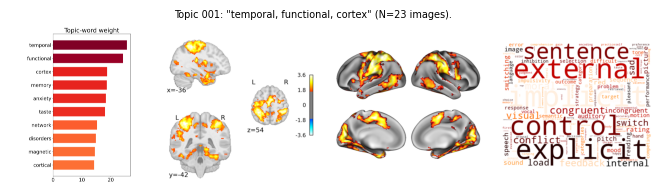

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

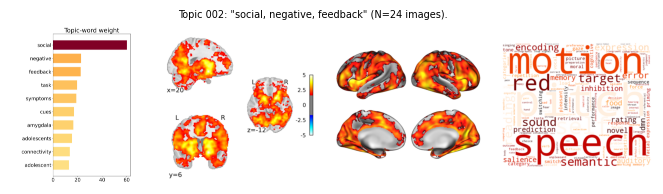

<Figure size 640x480 with 0 Axes>

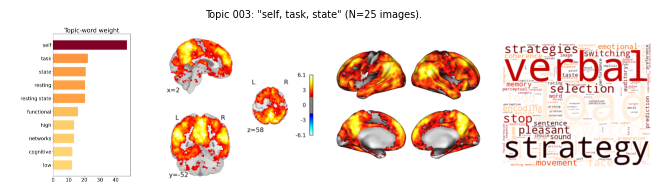

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

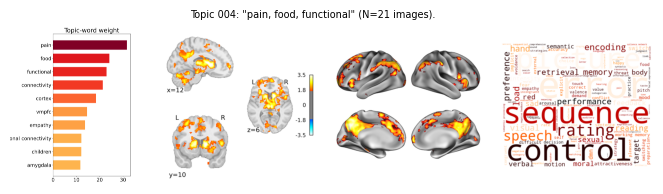

<Figure size 640x480 with 0 Axes>

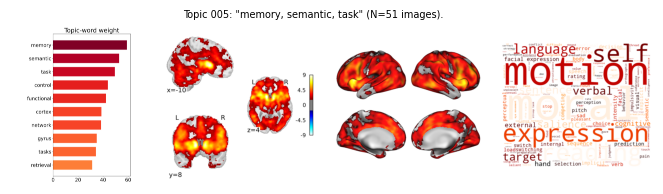

<Figure size 640x480 with 0 Axes>

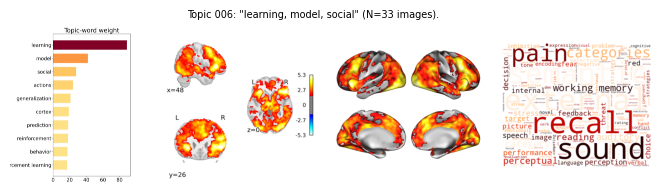

<Figure size 640x480 with 0 Axes>

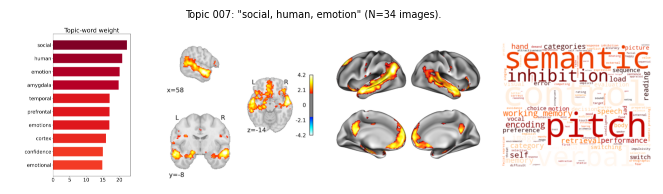

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

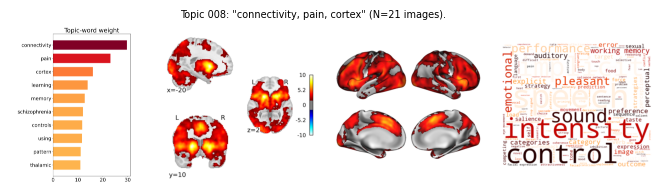

<Figure size 640x480 with 0 Axes>

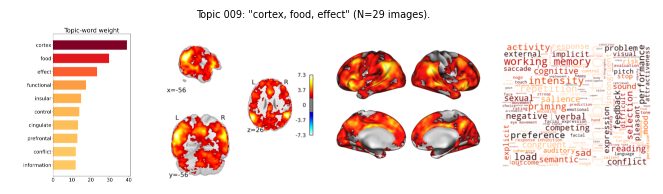

<Figure size 640x480 with 0 Axes>

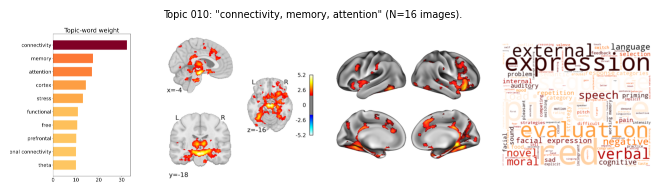

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

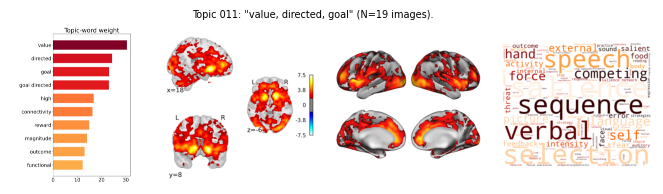

<Figure size 640x480 with 0 Axes>

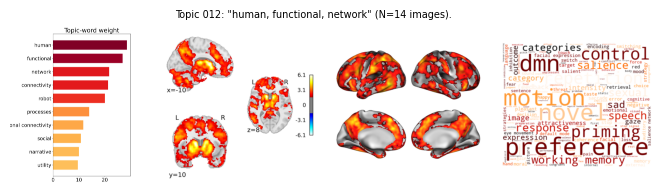

<Figure size 640x480 with 0 Axes>

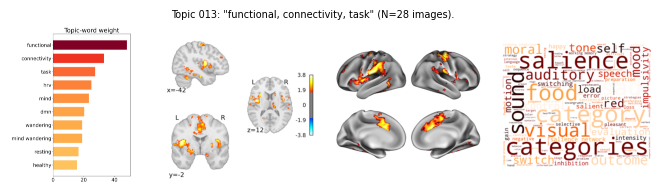

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

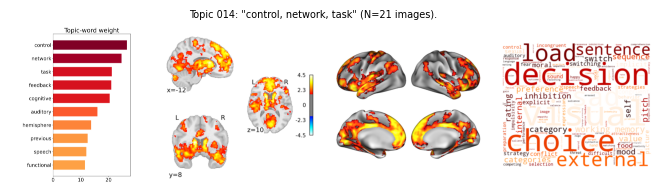

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.6517385881986395. But, you have given threshold=1.65.
  warnings.warn(
/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


<Figure size 640x480 with 0 Axes>

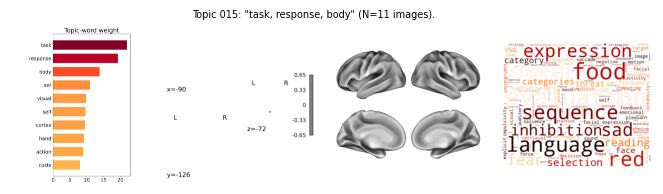

<Figure size 640x480 with 0 Axes>

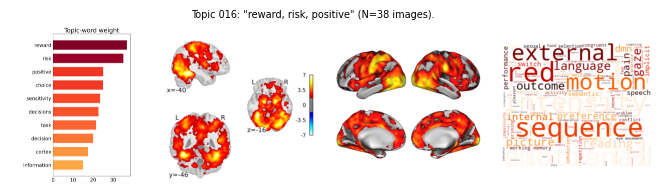

<Figure size 640x480 with 0 Axes>

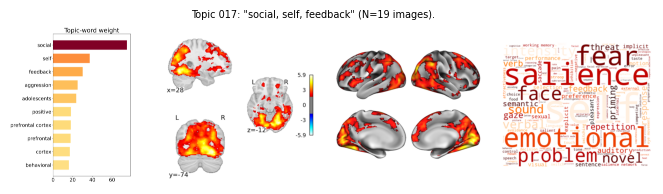

<Figure size 640x480 with 0 Axes>

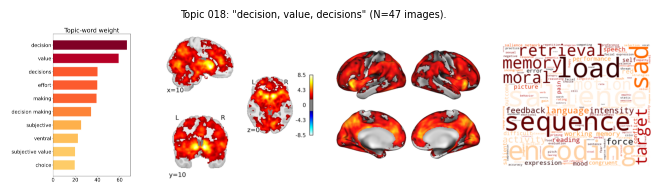

<Figure size 640x480 with 0 Axes>

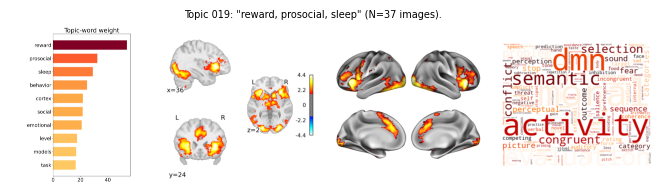

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

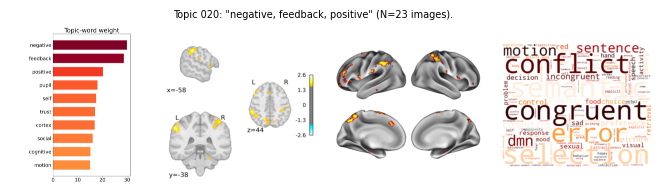

<Figure size 640x480 with 0 Axes>

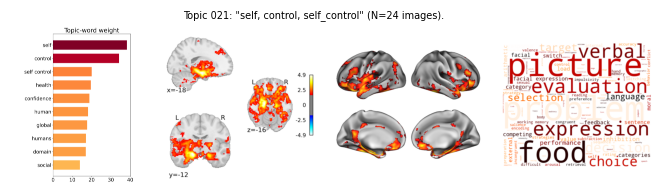

<Figure size 640x480 with 0 Axes>

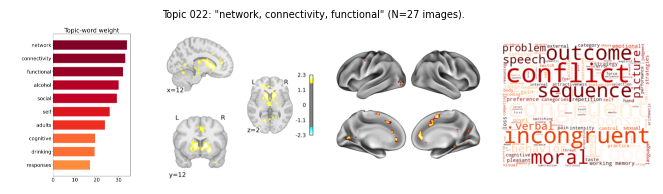

<Figure size 640x480 with 0 Axes>

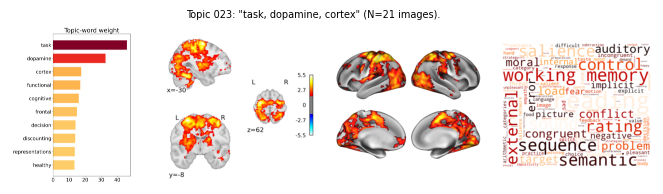

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

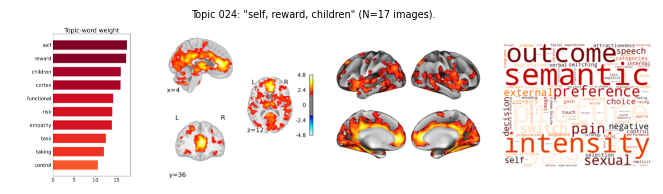

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


<Figure size 640x480 with 0 Axes>

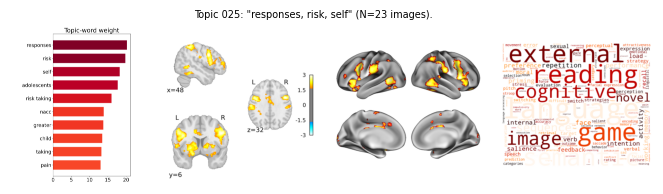

In [11]:
model_figures(model, dset, op.join(results_dir, "filtered"), fig_dec_dir, cmap="gist_heat")